Please use the 'get_instances' function below to get the 10 instances to compare the models with.

In [ ]:
# Write a single-file, non-API-style Python script.
# Minimal procedural style: constants + helper funcs + PROFILES dict + generate_scenario() + get_instances() + main block.
# Then emit JSONs to /mnt/data/go_train_scenarios_plain/

from pathlib import Path
import numpy as np
import json
from time import time_ns
from matplotlib import pyplot as plt

# ---------------------------
# INPUTS
# ---------------------------
EXP_RIDERSHIP = {
    'Lakeshore West': 33239,
    'Lakeshore East': 25769,
    'Kitchener': 15071,
    'Milton': 13138,
    'Barrie': 8636,
    'Stouffville': 7341,
    'Richmond Hill': 4642
}

INTERVAL_SIZE = 5  # minutes, window is 4:00–6:00 PM (120 total)

# PROFILES:
# - Each profile has parameters tuned for realistic patterns.
# - global_scale: overall multiplier for the totals in EXP_RIDERSHIP
# - line_scales: per-line multipliers (e.g., CNE -> Lakeshore boost)
# - spread: random noise as fraction of per-interval mean
# - shape: "gaussian" or "beta"
# - peak_time_min/peak_width_min: Gaussian timing
# - beta_a/beta_b: Beta curve shape
# NOTE: These are intentionally different across 10 instances (Mon–Sun + Christmas + CNE + Valentines)
PROFILES = {
    "Monday":     {"seed": 101, "global_scale": 0.95, "spread": 0.10, "shape": "gaussian", "peak_time_min": 70, "peak_width_min": 26, "line_scales": {}},
    "Tuesday":    {"seed": 102, "global_scale": 1.05, "spread": 0.10, "shape": "gaussian", "peak_time_min": 75, "peak_width_min": 22, "line_scales": {}},
    "Wednesday":  {"seed": 103, "global_scale": 1.15, "spread": 0.10, "shape": "gaussian", "peak_time_min": 75, "peak_width_min": 22, "line_scales": {}},
    "Thursday":   {"seed": 104, "global_scale": 1.06, "spread": 0.10, "shape": "gaussian", "peak_time_min": 80, "peak_width_min": 24, "line_scales": {}},
    "Friday":     {"seed": 105, "global_scale": 0.88, "spread": 0.11, "shape": "gaussian", "peak_time_min": 60, "peak_width_min": 28, "line_scales": {}},
    "Saturday":   {"seed": 106, "global_scale": 0.55, "spread": 0.12, "shape": "gaussian", "peak_time_min": 90, "peak_width_min": 36, "line_scales": {}},
    "Sunday":     {"seed": 107, "global_scale": 0.50, "spread": 0.12, "shape": "gaussian", "peak_time_min": 85, "peak_width_min": 36, "line_scales": {}},
    "Christmas":  {"seed": 201, "global_scale": 1.2, "spread": 0.08, "shape": "gaussian", "peak_time_min": 60, "peak_width_min": 50, "line_scales": {}},
    "CNE":        {"seed": 202, "global_scale": 1.30, "spread": 0.2, "shape": "gaussian", "peak_time_min": 95, "peak_width_min": 22,
                   "line_scales": {'Lakeshore West': 1.60, 'Lakeshore East': 1.40}},
    "Valentines": {"seed": 203, "global_scale": 1.2, "spread": 0.2, "shape": "gaussian", "peak_time_min": 10, "peak_width_min": 26,
                   "line_scales": {'Lakeshore West': 1.03, 'Lakeshore East': 1.03}},
}

# ---------------------------
# HELPERS (simple procedural functions)
# ---------------------------

def time_labels(interval_size):
    labels = []
    for t in range(0, 120, interval_size):
        hour = 4 + (t // 60)
        minute = t % 60
        labels.append(f"{hour}:{minute:02d}")
    return labels

def gaussian_curve(num_points, peak_idx, width_pts):
    x = np.arange(num_points)
    curve = np.exp(-0.5 * ((x - peak_idx) / max(width_pts, 1e-6))**2)
    s = curve.sum()
    if s == 0:
        curve = np.ones(num_points)
        s = curve.sum()
    return curve / s

def beta_curve(num_points, a, b):
    x = np.linspace(0, 1, num_points)
    a = max(a, 0.1); b = max(b, 0.1)
    curve = (x**(a-1)) * ((1-x)**(b-1))
    curve[np.isnan(curve)] = 0
    s = curve.sum()
    if s == 0:
        curve = np.ones(num_points)
        s = curve.sum()
    return curve / s

def build_curve(shape, interval_size, peak_time_min=75, peak_width_min=24, beta_a=3.0, beta_b=3.0):
    num_points = 120 // interval_size
    if shape == "gaussian":
        peak_idx = int(round(peak_time_min / interval_size))
        width_pts = max(1, int(round(peak_width_min / interval_size)))
        return gaussian_curve(num_points, peak_idx, width_pts)
    elif shape == "beta":
        return beta_curve(num_points, beta_a, beta_b)
    else:
        raise ValueError("shape must be 'gaussian' or 'beta'")

# ---------------------------
# CORE GENERATION
# ---------------------------

def generate_scenario(seed=None, interval_size=INTERVAL_SIZE, global_scale=1.0, spread=0.10,
                      shape="gaussian", peak_time_min=75, peak_width_min=24, beta_a=3.0, beta_b=3.0,
                      line_scales=None):
    if seed is None:
        seed = time_ns()
    if not isinstance(seed, int):
        seed = sum(ord(c) for c in str(seed))
    np.random.seed(seed % (2**32 - 1))

    if line_scales is None:
        line_scales = {}

    labels = time_labels(interval_size)
    curve = build_curve(shape, interval_size, peak_time_min, peak_width_min, beta_a, beta_b)

    scenario = {}
    for line in EXP_RIDERSHIP:
        scenario[line] = {}

    for line, base_total in EXP_RIDERSHIP.items():
        lscale = line_scales.get(line, 1.0)
        target_total = base_total * global_scale * lscale

        mean_per_bucket = target_total * curve
        noise_std = np.maximum(1e-9, spread * mean_per_bucket)
        noisy = np.maximum(0.0, np.random.normal(loc=mean_per_bucket, scale=noise_std))

        s = noisy.sum()
        if s > 0:
            adjusted = noisy * (target_total / s)
        else:
            adjusted = np.ones_like(noisy) * (target_total / len(noisy))

        ints = np.floor(adjusted).astype(int)
        remainder = int(round(target_total - ints.sum()))
        if remainder > 0:
            # add to buckets with largest fractional parts
            remainders = (adjusted - ints).argsort()[::-1][:remainder]
            ints[remainders] += 1
        elif remainder < 0:
            # subtract from buckets with largest overshoot
            remainders = (ints - adjusted).argsort()[::-1][:(-remainder)]
            ints[remainders] -= 1

        for i, tlabel in enumerate(labels):
            scenario[line][tlabel] = int(max(0, ints[i]))

    return scenario

def get_instances(names=None):
    # Returns dict[name] -> scenario
    if names is None:
        names = list(PROFILES.keys())
    out = {}
    for name in names:
        p = PROFILES[name]
        out[name] = generate_scenario(
            seed=p["seed"],
            interval_size=INTERVAL_SIZE,
            global_scale=p["global_scale"],
            spread=p["spread"],
            shape=p["shape"],
            peak_time_min=p.get("peak_time_min", 75),
            peak_width_min=p.get("peak_width_min", 24),
            beta_a=p.get("beta_a", 3.0),
            beta_b=p.get("beta_b", 3.0),
            line_scales=p.get("line_scales", {})
        )
    return out

def save_jsons(instances, out_dir):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    paths = []
    for name, scen in instances.items():
        path = out_dir / f"scenario_{name.lower().replace(' ', '_')}.json"
        with open(path, "w", encoding="utf-8") as f:
            json.dump(scen, f, indent=2)
        paths.append(str(path))
    return paths


In [2]:
instances=get_instances()

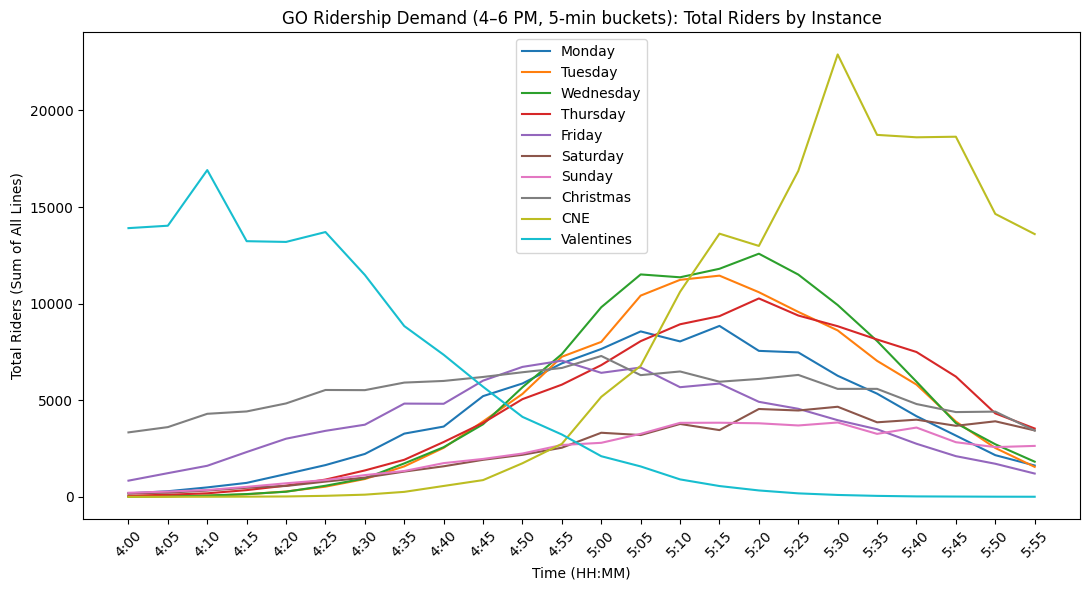

In [3]:


# Get time axis from any scenario (they share labels)
any_scen = next(iter(instances.values()))
time_axis = list(next(iter(any_scen.values())).keys())

# Sum across lines per time for each instance
def totals_over_time(scen):
    return [sum(scen[line][t] for line in scen) for t in time_axis]

plt.figure(figsize=(11, 6))
for name, scen in instances.items():
    plt.plot(time_axis, totals_over_time(scen), label=name)

plt.title("GO Ridership Demand (4–6 PM, 5-min buckets): Total Riders by Instance")
plt.xlabel("Time (HH:MM)")
plt.ylabel("Total Riders (Sum of All Lines)")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
#Getting json files with instances

paths = save_jsons(instances=get_instances(), out_dir="instances")

for path in paths:
    print(f"Instance '{path}' created and saved.")

Instance 'instances/scenario_monday.json' created and saved.
Instance 'instances/scenario_tuesday.json' created and saved.
Instance 'instances/scenario_wednesday.json' created and saved.
Instance 'instances/scenario_thursday.json' created and saved.
Instance 'instances/scenario_friday.json' created and saved.
Instance 'instances/scenario_saturday.json' created and saved.
Instance 'instances/scenario_sunday.json' created and saved.
Instance 'instances/scenario_christmas.json' created and saved.
Instance 'instances/scenario_cne.json' created and saved.
Instance 'instances/scenario_valentines.json' created and saved.
